# Hysteresis Processing

## Workflow for hysteresis processing

1) grid the original data by averaging field step size, and interpolate both the upper and lower branches of the hysteresis loop to the same field steps.
2) perform a linear fit on the original loop data for the high field slope (typically > 80% max field values and < 97% max field value) and subtract the linear fit from all the gridded data points. 
 perform paramagnetic/diamagnetic slope correction on the gridded data. Here we use both the upper and lower branches of the hysteresis loops and invert data points in the third quadrant to the first quadrant for line fitting (ordinary least squares) to estimate the paramagnetic/diamagnetic slope.
 
3) perform linearity test on the gridded original data (high field slope correction not applied)

4) at the same time, centering the high-field slope corrected data, and estimate the optimal values for field and moment offsets.
 Note that when iterating through different H_offset values on the inverted lower branch, the upper and lower branches will have a H field range mismatch. To account for this, in this code we just use the overlapping region for interpolation and ANOVA statistic.

 Testing with synthetic data shows that the exact offset results from this code is slightly different from that of the IRM database. But the results from this function `hyst_loop_centering` are self-consistent (add synthetic offset + or - results in the same corrected R^2 while the IRM function does not). Given that both functions finds the correct offset values, I use the new function

5) calculate the Q value to represent the signal/noise ratio (data quality) of the whole loop (ferromagnetic component + paramagnetic (also + diamagnetic component)) after centering. 
6) re-grid the original data with applying the estimated optimal values for field and moment offsets.
7) calculate H and M errors for each data point.
8) calculate mrh, E_hys, Brh, Bih
9) use the sum of M errors to estimate signal drift correction
10) test saturation of the loop by calculating the FN60, 70, 80 statistics and determine where the loop start to saturate.
11) re-apply high field slope correction to the drift-corrected data
12) calculate the Qf value using the drift-corrected, high-field slope corrected data for the ferromagnetic component quality estimate.
13) calculate Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc


## Install and import packages

In [2]:
import pmagpy.rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import data

We can take the same approach as in the `rockmag_data_unpack.ipynb` notebook to bring the MagIC data into the notebook as a Contribution. 

To bring in a different contribution than the one shown in this example:
-  set the directory path (currently `'./example_data/hyst'`)
-  set the `magic_id` (19216 for  *Swanson-Hysell et al., 2021*)
-  if the contribution is private, set the share key for your MagIC contribution which you can find by clicking on the "Share" button in the MagIC database.

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/MagIC_private_contribution_1.png" alt="Description of the image" width="800">
</figure>

## Load local data
In this demonstration we will be using local data.

The data is from the following publication:
- Swanson-Hysell, N. L., Avery, M. S., Zhang, Y., Hodgin, E. B., Sherwood, R. J., Apen, F. E., et al. (2021). The paleogeography of Laurentia in its early years: New constraints from the Paleoproterozoic East-Central Minnesota Batholith. Tectonics, 40, e2021TC006751. https://doi.org/10.1029/2021TC006751

In [3]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('ECMB 2018.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

working on:  'contribution\r'
1  records written to file  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/contribution.txt
  data put in  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/contribution.txt
working on:  'specimens\r'
15  records written to file  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
  data put in  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/specimens.txt
working on:  'samples\r'
5  records written to file  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
  data put in  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/samples.txt
working on:  'sites\r'
5  records written to file  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
  data put in  /Users/unimos/0000_Github/RockmagPy-notebooks/example_data/ECMB/sites.txt
working on:  'locations\r'
10  records written to file  /Users/unimos/0000_Github/RockmagPy-notebooks/ex

## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

## Inspect the original data

In [ ]:
specimen = rmag.make_hyst_plots(measurements)

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED4-1c', 'NED6-6c'), value='NED…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

Output()

## Loop processing

We aim to offer the ability to calculate the hysteresis loop parameters as available in the IRMDB software, with the goal of being able to export the statistics into the MagIC specimen data table. 

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/IRM_hyst_processing_screenshot.png" alt="Description of the image" width="800">
</figure>

The automated processing function will follow the workflow presented in Paterson et al., 2018

<figure>
  <img src="https://raw.githubusercontent.com/PmagPy/RockmagPy-notebooks/main/book/images/hyst_loo_processing_workflow.png" alt="Description of the image" width="500">
</figure>


### select specimen hysteresis data

In [14]:
# extract the specimen specific data, for this demonstration, we use specimen NED18-2c
specimen = 'NED2-8c'
hyst_data = rmag.extract_hysteresis_data(measurements, specimen)

loop_fields = hyst_data['meas_field_dc']
loop_magnetizations = hyst_data['magn_mass']

### execute default hysteresis processing procedure following the flowchart above

In [15]:
np.where(loop_fields == np.max(loop_fields))[0]

array([  0, 801])

check loop drift!
raw data is not linear
FNL:  7774.59
loop centering results: field offset = 0.0 T magnetization offset = 0.0006 Am^2/kg
centered raw loop Q value: 2.91
apply default high field linear correction: slope (X_para/dia) = 0.174 intercept (Ms) = 0.0426 Am^2/kg
centered ferromagnetic loop Qf value: 2.29
SNR = 12.33 dB
HAR = -21.26 dB
loop is still open!
Ms = 0.0426 Am^2/kg
Mr = 0.0068 Am^2/kg
Bc = 15.86 mT
Brh = 50.07 mT
loop is not saturated! check non-linear high field correction!


,specimen,Q,Qf,Ms,Mr,Bc,Brh,FNL,method_codes
0,NED2-8c,2.914021,2.294866,0.042641,0.006791,0.015862,0.050073,7774.591351,LP-HYS


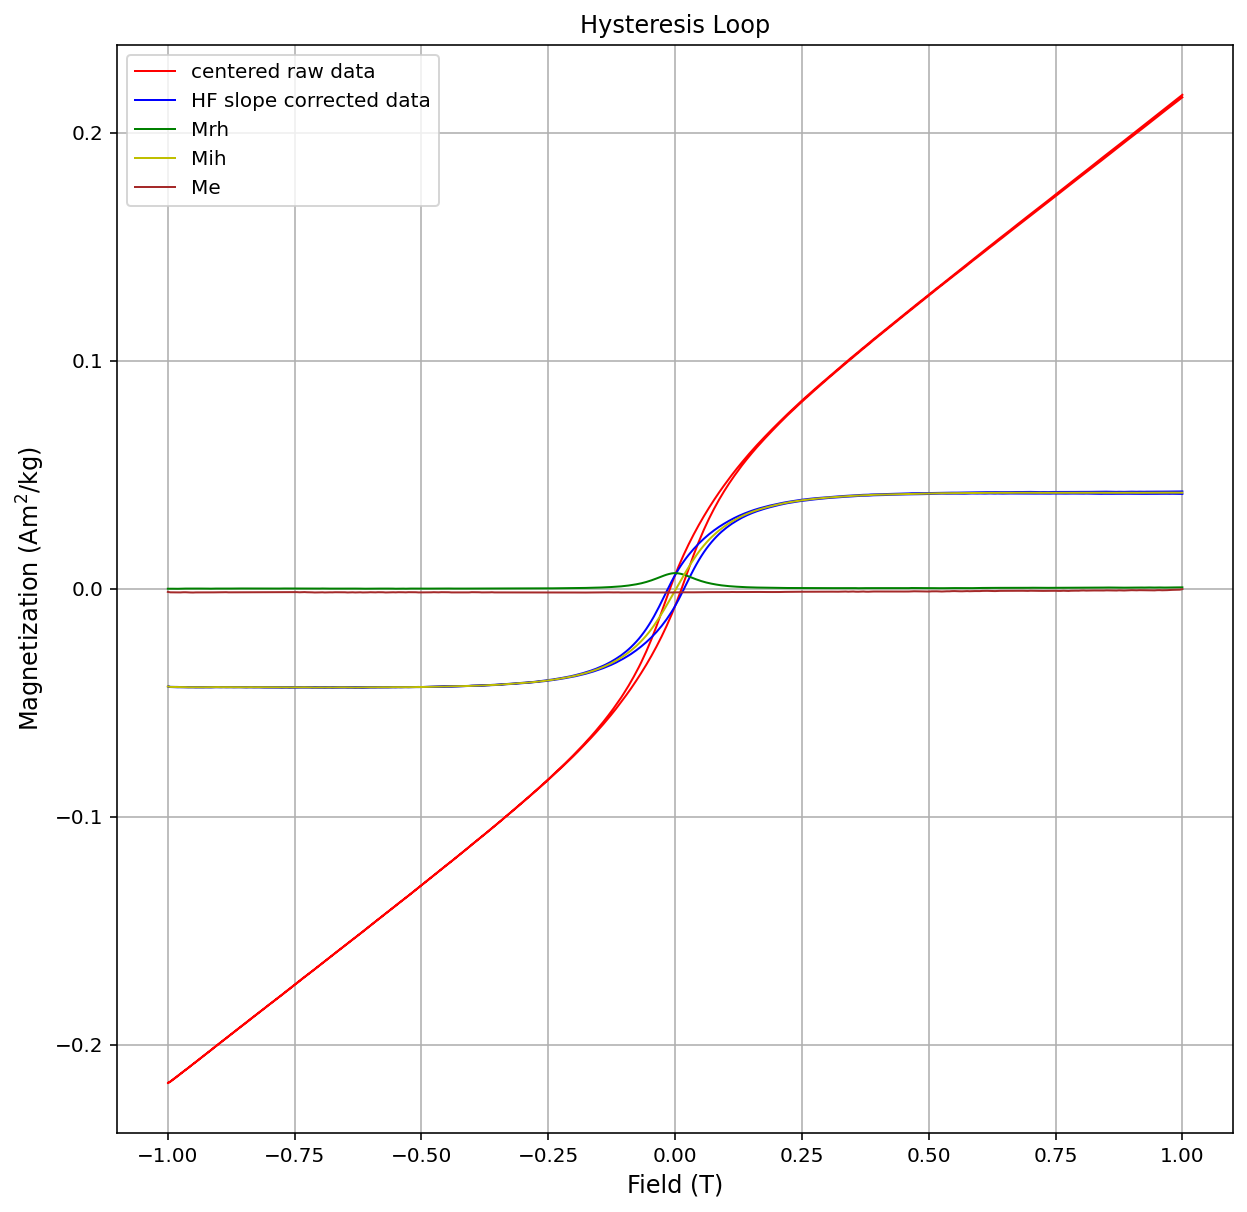

In [16]:
results, ax = rmag.process_hyst_loop(loop_fields, loop_magnetizations)
rmag.export_hyst_specimen_table(specimen, results)

## export this specimen hyseresis data to a specimen data table that can be merged with other specimen level MagIC tables

,specimen,Q,Qf,Ms,Mr,Bc,Bcr,FNL,method_codes
0,NED1-5c,3.188326,2.59592,0.033942,0.006029,0.014194,0.04078,10478.662624,LP-HYS
